In [2]:
!pip install huggingface_hub
!pip install dghs-imgutils
!pip install hbutils>=0.9.1
# opencv-python
# numpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for dghs-imgutils from https://files.pythonhosted.org/packages/de/bb/38a6f175d37c2f27d3e63e6223c29aa2b50e798b12c38c46c2526a6f88af/dghs_imgutils-0.3.5-py3-none-any.whl.metadata
  Obtaining dependency information for hbutils>=0.9.0 from https://files.pythonhosted.org/packages/04/22/e1d36fe06f092536000a32efa156e3acf2ce585a36501521f09123d02fd6/hbutils-0.9.3-py3-none-any.whl.metadata
  Obtaining dependency information for opencv-contrib-python from https://files.pythonhosted.org/packages/4c/c3/ccff2e1bfe2bb47a7eaebc4280e93bd2f97ebbe5b3573d48bcfcc0c32387/opencv_contrib_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for emoji>=2.5.0 from https://files.pythonhosted.org/packages/98/00/00d56e704d69cee4a92b1d517676579b4af5f2f8bc72946c464a504705b2/emoji-2.10.1-py2.py3-none-an

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 7.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 7.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.2/279.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for bitmath: filename=bitmath-1.3.3.1-py3-none-any.whl size=23976 sha256=1deeb116a30b7fe939783549bef96dba4d7b32044d17422f14500e21362ce100
  Stored in directory: /private/var/folders/bc/4d78jrn15m924n8pt76chnf40000gr/T/pip-ephem-wheel-cache-uz9rmgd5/wheels/67/e1/c6/53fefee471c8a8660c919f42b566008a60cd2ee82254d6f7c1
Successfully built bitmath
zsh:1: 0.9.1 not found


In [3]:
import cv2
import os.path
import numpy as np
from typing import List, Tuple
from functools import lru_cache
from imgutils.data import ImageTyping
from imgutils.utils import open_onnx_model
from imgutils.detect import detection_visualize
from huggingface_hub import HfApi, HfFileSystem, hf_hub_download

In [4]:
hf_client = HfApi()
hf_fs = HfFileSystem()


@lru_cache()
def _get_available_models():
    for f in hf_fs.glob('deepghs/text_detection/*/end2end.onnx'):
        yield os.path.relpath(f, 'deepghs/text_detection').split('/')[0]


_ALL_MODELS = list(_get_available_models())
_DEFAULT_MODEL = 'dbnetpp_resnet50_fpnc_1200e_icdar2015'


@lru_cache()
def _get_onnx_session(model):
    return open_onnx_model(hf_hub_download(
        'deepghs/text_detection',
        f'{model}/end2end.onnx'
    ))


def _get_heatmap_of_text(image: ImageTyping, model: str) -> np.ndarray:
    origin_width, origin_height = width, height = image.size
    align = 32
    if width % align != 0:
        width += (align - width % align)
    if height % align != 0:
        height += (align - height % align)

    input_ = np.array(image).transpose((2, 0, 1)).astype(np.float32) / 255.0
    # noinspection PyTypeChecker
    input_ = np.pad(input_[None, ...], ((0, 0), (0, 0), (0, height - origin_height), (0, width - origin_width)))

    def _normalize(data, mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)):
        mean, std = np.asarray(mean), np.asarray(std)
        return (data - mean[None, :, None, None]) / std[None, :, None, None]

    ort = _get_onnx_session(model)

    input_ = _normalize(input_).astype(np.float32)
    output_, = ort.run(['output'], {'input': input_})
    heatmap = output_[0]
    heatmap = heatmap[:origin_height, :origin_width]

    return heatmap


def _get_bounding_box_of_text(image: ImageTyping, model: str, threshold: float) \
        -> List[Tuple[Tuple[int, int, int, int], float]]:
    heatmap = _get_heatmap_of_text(image, model)
    c_rets = cv2.findContours((heatmap * 255.0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = c_rets[0] if len(c_rets) == 2 else c_rets[1]
    bboxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x0, y0, x1, y1 = x, y, x + w, y + h
        score = heatmap[y0:y1, x0:x1].mean().item()
        if score >= threshold:
            bboxes.append(((x0, y0, x1, y1), score))

    return bboxes


def detect_text(image: ImageTyping, model: str = _DEFAULT_MODEL, threshold: float = 0.05):
    bboxes = []
    for (x0, y0, x1, y1), score in _get_bounding_box_of_text(image, model, threshold):
        bboxes.append(((x0, y0, x1, y1), 'text', score))
    return bboxes

In [100]:
from PIL import Image

image_path = f'./findit2/torchdataset/val/1/X51006555125.png'

# Load the original image
image = Image.open(image_path).convert('RGB')

In [101]:
model = _DEFAULT_MODEL
threshold = 0.05

In [102]:
detect_text(image, model, threshold)

[((385, 957, 446, 977), 'text', 0.3020177185535431),
 ((260, 955, 383, 978), 'text', 0.25570428371429443),
 ((206, 955, 253, 974), 'text', 0.3339923620223999),
 ((136, 955, 202, 975), 'text', 0.36037278175354004),
 ((144, 929, 208, 946), 'text', 0.45202651619911194),
 ((260, 928, 444, 946), 'text', 0.3704589903354645),
 ((210, 928, 256, 946), 'text', 0.4093862473964691),
 ((476, 768, 518, 788), 'text', 0.11564274877309799),
 ((117, 766, 156, 788), 'text', 0.37624993920326233),
 ((57, 766, 85, 786), 'text', 0.21058867871761322),
 ((297, 765, 364, 785), 'text', 0.3886224031448364),
 ((108, 738, 200, 761), 'text', 0.20390766859054565),
 ((235, 736, 360, 754), 'text', 0.3995518684387207),
 ((430, 734, 518, 758), 'text', 0.18109075725078583),
 ((60, 730, 96, 754), 'text', 0.08608300238847733),
 ((500, 696, 552, 716), 'text', 0.153787299990654),
 ((270, 695, 357, 711), 'text', 0.45703378319740295),
 ((498, 664, 554, 685), 'text', 0.3758138120174408),
 ((271, 662, 330, 681), 'text', 0.4527332

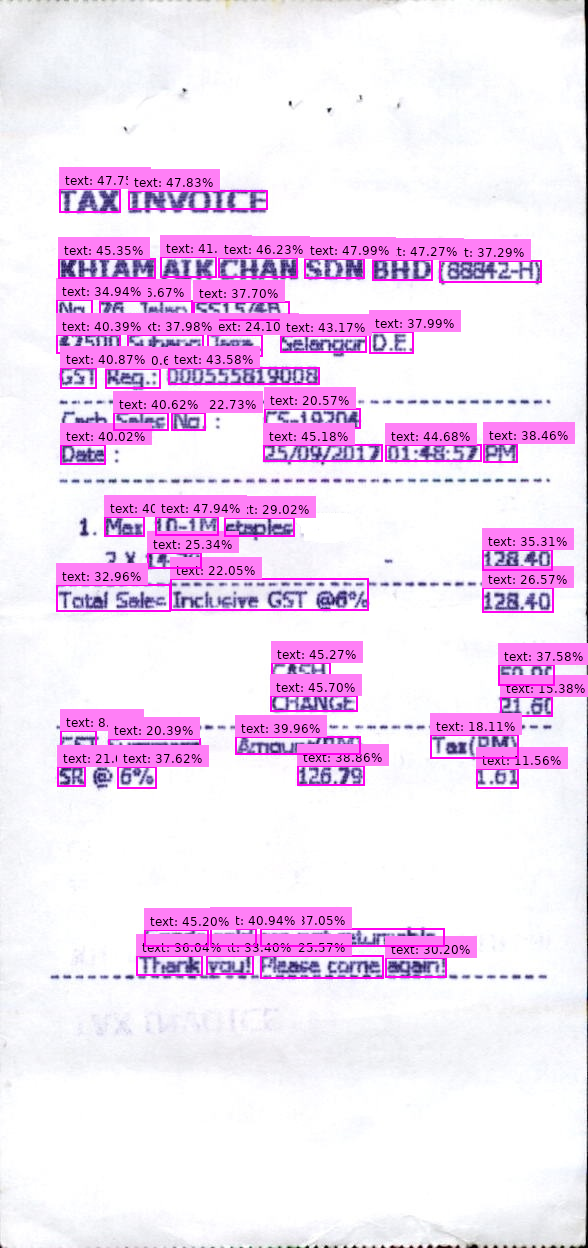

In [112]:
detection_visualize(image, detect_text(image, model, threshold))